## DAT490 Project: Expanded Analysis

In [6]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# stock history file
stock_data= "filtered_and_named_stock_data.csv"
stock_df = pd.read_csv(stock_data)

# web scraped news file
news_data= "new_fulL_df.csv"
news_df = pd.read_csv(news_data)

# merge datasets
complete_misinfo_sample = news_df.merge(stock_df, on=['Stock', 'Date'], how='left')

# save
complete_misinfo_sample.to_csv("complete_misinfo_sample_new.csv", index=False, encoding='utf-8-sig')

print("Merged file saved.")

Merged file saved.


In [7]:
complete_misinfo_sample.dtypes

Stock               object
Date                object
Headline            object
Snippet             object
Label               object
Open               float64
High               float64
Low                float64
Close              float64
Volume             float64
Return             float64
Volatility         float64
Ticker              object
EWMA_Volatility    float64
dtype: object

In [8]:
# Preprocessing steps and a RF Regressor model to analyze our data, targeting Volatility as y

# data file
df = pd.read_csv("complete_misinfo_sample_new_with_sentiment.csv")

# change misinfo label map
df['Label'] = df['Label'].map({'Real': 1, 'Fake': 0})

# some additional finance-related features
df['Range'] = df['High'] - df['Low']
df['Range_over_Close'] = df['Range'] / df['Close'].replace(0, np.nan)
df['Percent_Change'] = ((df['Close'] - df['Open']) / df['Open'].replace(0, np.nan)) * 100

# drop unnecessary features and nulls
X = df.drop(columns=['Date', 'Volatility', 'EWMA_Volatility', 'Stock', 'Ticker', 'Snippet', 'Headline'])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)

# target variable
y = df.loc[X.index, 'Volatility']

# StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Random Forest Regressor model using GridSearchCV for hyperparameter tuning
RFReg = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(estimator=RFReg, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled, y)

# print best params
print("Best hyperparameters: ", grid_search.best_params_)

# best model
best_model = grid_search.best_estimator_

# cross-validation
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5, scoring='neg_mean_absolute_error')
print("(CV) MAE: ", cv_scores)
print("(CV) Average MAE: {:.4f}".format(cv_scores.mean()))

# train-test-split 80-20
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# fit model and predict
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print metric results
print("\nTest Evaluation:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R2 Score: {r2:.4f}")

C:\Users\Garrett\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best hyperparameters:  {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
(CV) MAE:  [-0.0379094  -0.01157124 -0.0070286  -0.01065997 -0.0238994 ]
(CV) Average MAE: -0.0182

Test Evaluation:
Mean Absolute Error: 0.0101
Mean Squared Error: 0.0002
R2 Score: 0.5678


In [9]:
# Misinfo label statistics and a Mann-Whitney U test with a copy dataframe

# copy and split by misinformation label
df_compare = df.copy()

df_real = df_compare[df_compare['Label'] == 0]
df_fake = df_compare[df_compare['Label'] == 1]

# print stats on misinformation label across dataset
print("Real News Stats:\n", df_real[['Volatility', 'Return', 'Volume']].describe())
print("\nFake News Stats:\n", df_fake[['Volatility', 'Return', 'Volume']].describe())

# Mann-Whitney U test on Volatility for both label classes of misinformation
t_stat, p_val = ttest_ind(df_fake['Volatility'], df_real['Volatility'], equal_var=False)
print(f"\nT-test for Volatility: t-stat = {t_stat:.4f}, p-value = {p_val:.4f}")

Real News Stats:
        Volatility      Return        Volume
count  977.000000  977.000000  9.770000e+02
mean     0.070400    0.023439  1.228287e+07
std      0.021525    0.056962  4.150464e+07
min      0.030800   -0.135300  6.710000e+04
25%      0.057100   -0.029200  1.673300e+06
50%      0.066700    0.032600  3.606500e+06
75%      0.077500    0.061400  8.793000e+06
max      0.194600    0.161600  5.424440e+08

Fake News Stats:
         Volatility       Return        Volume
count  1263.000000  1263.000000  1.263000e+03
mean      0.071583     0.021402  1.123907e+07
std       0.021709     0.059488  3.671664e+07
min       0.030800    -0.211300  6.710000e+04
25%       0.058300    -0.031400  1.468600e+06
50%       0.068500     0.035400  3.272800e+06
75%       0.078700     0.060800  7.452900e+06
max       0.194600     0.161600  5.424440e+08

T-test for Volatility: t-stat = 1.2853, p-value = 0.1988


In [10]:
# Combining sentiment scores into three classes for each record in the final dataset

# copied for additional sentiment manipulation and plots
df_combosentiment = df_compare.copy()

df_combosentiment['Sentiment_Level'] = pd.cut(df_combosentiment['Combined_Sentiment'],
                                        bins=[-1, -0.1, 0.1, 1],
                                        labels=['Negative', 'Neutral', 'Positive'])

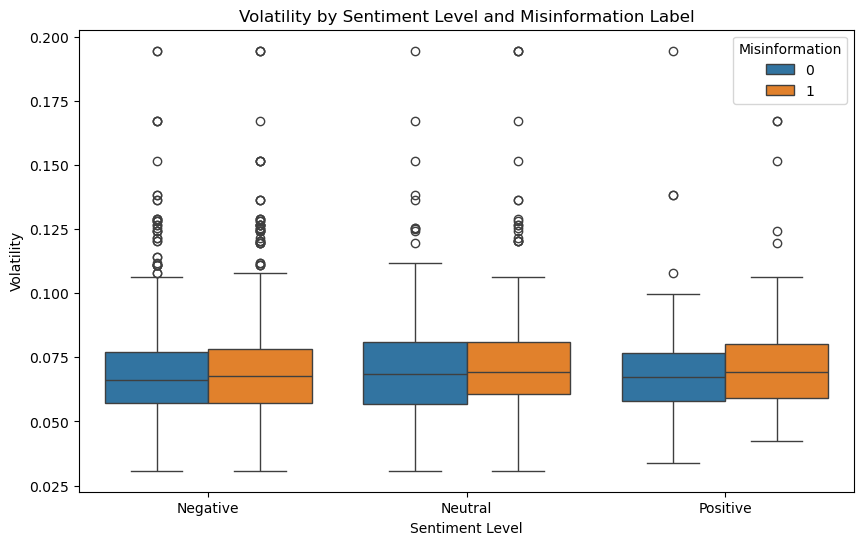

In [11]:
# Volatility by Sentiment and Misinformation Label plot

plt.figure(figsize=(10,6))

sns.boxplot(data=df_combosentiment, x='Sentiment_Level', y='Volatility', hue='Label')
plt.title('Volatility by Sentiment Level and Misinformation Label')
plt.ylabel('Volatility')
plt.xlabel('Sentiment Level')
plt.legend(title='Misinformation')

plt.show()

Sentiment_Level Distribution:
Sentiment_Level
Negative    1566
Neutral      475
Positive     199
Name: count, dtype: int64


C:\Users\Garrett\AppData\Local\Temp\ipykernel_22152\2113535276.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Level', data=df_combosentiment, palette='coolwarm', order=df_combosentiment['Sentiment_Level'].value_counts().index)


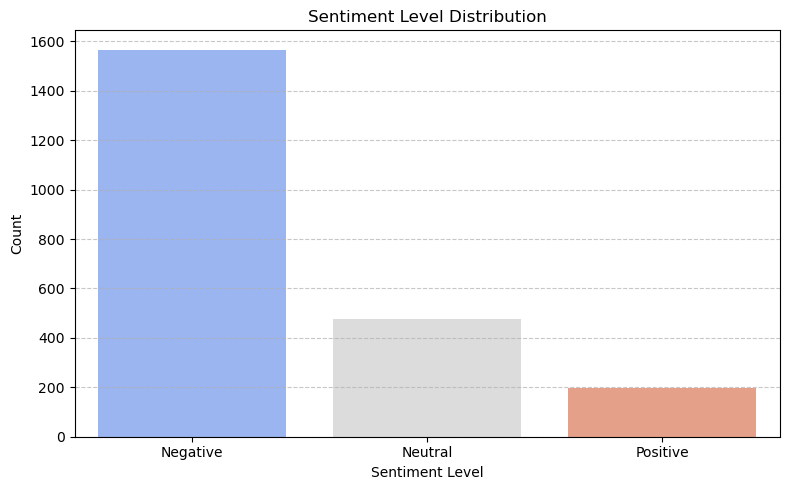

In [12]:
# Distribution of Sentiment plot

# print sentiment level distribution before plot
print("Sentiment_Level Distribution:")
print(df_combosentiment['Sentiment_Level'].value_counts())

plt.figure(figsize=(8, 5))

sns.countplot(x='Sentiment_Level', data=df_combosentiment, palette='coolwarm', order=df_combosentiment['Sentiment_Level'].value_counts().index)
plt.title('Sentiment Level Distribution')
plt.xlabel('Sentiment Level')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()